In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:04<00:00, 41117547.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

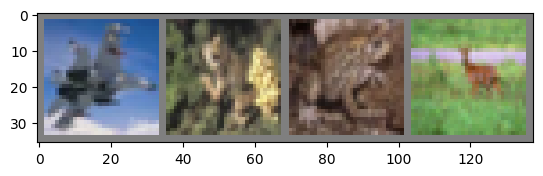

plane frog  frog  deer 


In [4]:
def imshow(img):
  img = img/2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)  # Flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [11]:
for epoch in range(2):  # Loop over the dataset multiple times

  running_loss = 0.8
  for i, data in enumerate(trainloader, 0):
    # get the inpyts; data is a list of [inputs, labels]
    inputs, labels = data

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + Backward + Optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print Statistics
    running_loss += loss.item()
    if i % 2000 == 1999:  # Print every 2000 mini-batches
      print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
      running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 2.212
[1,  4000] loss: 1.820
[1,  6000] loss: 1.652
[1,  8000] loss: 1.533
[1, 10000] loss: 1.499
[1, 12000] loss: 1.453
[2,  2000] loss: 1.398
[2,  4000] loss: 1.376
[2,  6000] loss: 1.334
[2,  8000] loss: 1.301
[2, 10000] loss: 1.309
[2, 12000] loss: 1.267
Finished Training: 


In [12]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

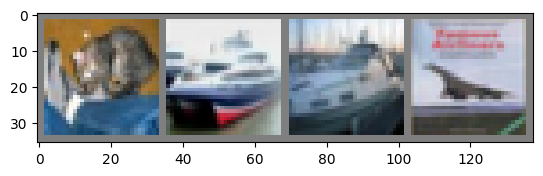

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print Images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only = True))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  cat   ship  car   plane


In [20]:
correct = 0
total = 0

# Since we are not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for data in testloader:
    images, labels = data
    # Calculate outputs by running images through the network
    outputs = net(images)
    # The class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total}%")

Accuracy of the network on the 10000 test images: 55%


In [22]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again no gradients needed
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # Collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f"Accuracy for class: {classname:5s} is {accuracy:.1f}%")

Accuracy for class: plane is 67.9%
Accuracy for class: car   is 81.0%
Accuracy for class: bird  is 50.2%
Accuracy for class: cat   is 20.0%
Accuracy for class: deer  is 47.8%
Accuracy for class: dog   is 50.0%
Accuracy for class: frog  is 70.7%
Accuracy for class: horse is 63.1%
Accuracy for class: ship  is 68.9%
Accuracy for class: truck is 39.0%
